In this notebook we demonstrate how we can train a neural network on a system of ODEs to reproduce results. There are two main ways this is done: supervised and unsupervised. In the supervised case, we give the neural network a numerical solution, against which it computes loss via least squares. In the unsupervised case, our loss function is instead given by the ODE itself.

In this notebook we only demonstrate a supervised solution approach.

In [50]:
from scipy.integrate import solve_ivp

# We recreate our systems of ODEs, exactly as in the other notebook.

t = np.arange(0, 1800, 1, dtype=float)
meal_t = np.array([300, 650, 1100])
meal_q = np.array([60e3, 40e3, 50e3])
Vp=3
Vi=11
Vg=10
E=0.2
tp=6
ti=100
td=12
k=1 / 120
Rm=209
a1=6.6
C1=300
C2=144
C3=100
C4=80
C5=26
Ub=72
U0=4
Um=90
Rg=180
alpha=7.5
beta=1.772
    
y0 = np.array([12.0 * Vp, 4.0 * Vi, 110.0 * Vg, 0.0, 0.0, 0.0]) # Initial condition
    
def sbode(t,y): # For a given state and time, we obtain the values for our partial derivatives
    f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
    f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
    kappa = (1 / Vi + 1 / E / ti) / C4
    f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
    f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
    IG = np.sum(
        meal_q * k * np.exp(k * (meal_t - t)) * np.heaviside(t - meal_t, 0.5)
    )
    tmp = E * (y[0] / Vp - y[1] / Vi)
    return np.array([
        f1 - tmp - y[0] / tp,
        tmp - y[1] / ti,
        f4 + IG - f2 - f3 * y[2],
        (y[0] - y[3]) / td,
        (y[3] - y[4]) / td,
        (y[4] - y[5]) / td,
    ])

(10003, 6)

Text(0.5, 0, 'Time (mins)')

Text(0, 0.5, '$I_p$  ( μU/ml )')

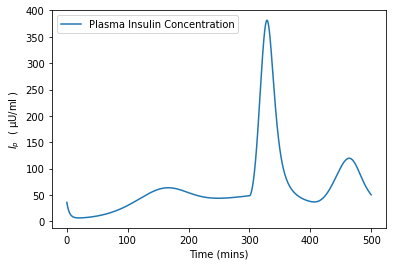

In [115]:
# In this case we will use SciPy's solve_ivp function, and look at a much smaller window, with more datapoints.

sol = solve_ivp(sbode, (0, 500), y0, max_step = 0.05)
sol.y.T.shape

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T[:,0])
plt.legend(['Plasma Insulin Concentration'])
plt.xlabel('Time (mins)')
plt.ylabel('$I_p$  ( μU/ml )')

In [108]:
import autograd.numpy as np
from autograd import grad,
import autograd.numpy.random
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, r=npr.RandomState(0)):
    return [(r.randn(insize, outsize) * scale,   # weight matrix
             r.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    # The activation function of our choice.
    return x / (1.0 + np.exp(-x))

def SB(params, inputs):
    # This is where the NN takes in the current parameters and outputs its solution guess
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
    return outputs

# The layer size provided here seemed to be most effective, but more experimentation with other layer structures may be of interest
params = init_random_params(0.1, layer_sizes=[1, 10, 10, 10, 6])

In [109]:
%%time

def loss(params, step):
    return np.sum((sol.y.T - SB(params, sol.t.reshape([-1, 1])))**2)

for i in range(200):
    params = adam(grad(loss), params,
                  step_size=0.0001, num_iters=1000)

Text(0.5, 0, 'Time (mins)')

Text(0, 0.5, '$I_p$ ( μU/ml )')

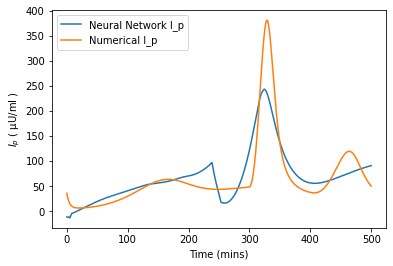

In [116]:
plt.plot(sol.t.reshape([-1, 1]), SB(params, sol.t.reshape([-1, 1]))[:,0],
         sol.t, sol.y.T[:,0])
plt.legend(['Neural Network I_p','Numerical I_p'])
plt.xlabel('Time (mins)')
plt.ylabel('$I_p$ ( μU/ml )')

Neural network-based solutions take much longer to compute to get reasonable accuracy, and so often requires more computing power. Nevertheless, it is clear that as a proof of concept, this method works. The next step would be to perform unsupervised training by using the ODE as the loss function. However, those solutions take even longer to process, and so may not be feasible on my laptop.